<a href="https://colab.research.google.com/github/JeanLuc-Oudshoorn/Net_Merchandise_Value/blob/master/nmv_model_in_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Machine Learning Model to Forecast Net Merchandise Value

In this notebook we will be building an adaptive model to forecast NMV. In order to do so, we have to explode the data which will result in a very large input dataframe. Therefore the pyspark API will be used to train the model.

### Installing PySpark on Colab

A few commands are needed to install and activate pyspark on colab. This should only take about a minute.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

In [3]:
import findspark
findspark.init()

If pyspark is successfully loaded in the environment we can now create a spark session. We can give it a name and add external repositories and packages with the 'config' option. The command below loads the pyspark implementation for the lightgbm algorithm.

In [4]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("NMV Model")\
                                        .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.0")\
                                        .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven")\
                                        .getOrCreate()

We can now check if the spark session is build correctly. In this case it will only be a local session, so we could also have used pandas. In reality, the application would be run on a Hadoop cluster.

In [5]:
spark

### Loading the simulated data

For this example we will be using a *simulated* data set, specifically developed for this training. Because the data is fake, it might contain some quirks that you would not see in real data (e.g.: strange color & product group combinations). We can read the file directly from the GitHub link and add it to the spark session.

In [6]:
from pyspark import SparkFiles
url = 'https://raw.githubusercontent.com/JeanLuc-Oudshoorn/Net_Merchandise_Value/master/fashion_data_simulation.csv'

spark.sparkContext.addFile(url)

df = spark.read.csv("file://"+SparkFiles.get("fashion_data_simulation.csv"), header=True, inferSchema= True)

The data looks as follows. In a real NMV project it will most likely be required to load historical orders and product information as two separate tables and join them togheter. For sake of simplicity, this step is skipped here.

In [7]:
df.show()

+-----+-------+--------+-----------+-------------+-------------+----+---------------+------------+-------+-----+-----------+----------+-------------+-----------+
|color|  brand|order_id|customer_id|product_group|product_class|size|sold_to_country|prod_country|    fit|price|is_returned|order_date|item_trans_id|return_date|
+-----+-------+--------+-----------+-------------+-------------+----+---------------+------------+-------+-----+-----------+----------+-------------+-----------+
|  red|   Zara|     186|      17679|        Dress|    Non-denim|   L|          Spain|  Bangladesh|   Slim|   89|          0|2021-08-01|            0|       null|
|beige|   Zara|     526|         77|          Tee|    Non-denim|   S|    Switzerland|     Vietnam|   Slim|   96|          0|2021-08-01|            1|       null|
|  red|   Zara|     830|      23059|      Handbag|  Accessories|null|        Germany|    Portugal|   null|  118|          0|2021-08-01|            2|       null|
|beige|   Zara|    1274|    

### Feature Engineering

#### Date Features
Clearly, there are some opportunities for feature engineering in this data. For example, the order date cannot be used in its current form. Instead we can derive new predictive features from the order date.

In [8]:
from pyspark.sql import functions as F

# Order day of year
df = df.withColumn('day_of_year', F.dayofyear(F.col('order_date')))

# Order year
df = df.withColumn('year', F.year(F.col('order_date')))

# Order month
df = df.withColumn('month', F.month(F.col('order_date')))

# Order week of year
df = df.withColumn('week_of_year', F.weekofyear(F.col('order_date')))

We can now check to see if the new features were created properly.

In [9]:
df.show()

+-----+-------+--------+-----------+-------------+-------------+----+---------------+------------+-------+-----+-----------+----------+-------------+-----------+-----------+----+-----+------------+
|color|  brand|order_id|customer_id|product_group|product_class|size|sold_to_country|prod_country|    fit|price|is_returned|order_date|item_trans_id|return_date|day_of_year|year|month|week_of_year|
+-----+-------+--------+-----------+-------------+-------------+----+---------------+------------+-------+-----+-----------+----------+-------------+-----------+-----------+----+-----+------------+
|  red|   Zara|     186|      17679|        Dress|    Non-denim|   L|          Spain|  Bangladesh|   Slim|   89|          0|2021-08-01|            0|       null|        213|2021|    8|          30|
|beige|   Zara|     526|         77|          Tee|    Non-denim|   S|    Switzerland|     Vietnam|   Slim|   96|          0|2021-08-01|            1|       null|        213|2021|    8|          30|
|  red|   

#### Geometric Transformations
One-hot encoding the day of year will lead to many new columns in the data. Below is an example of how to geometrically transform this feature.

In [10]:
import numpy as np

# Sine base function
def sin_base(x, period=365.25):
    return float(np.sin(x / period * 2 * np.pi))

# Cosine base function
def cos_base(x, period=365.25):
    return float(np.cos(x / period * 2 * np.pi))

# Convert into PySpark function
sin_transformer = F.udf(lambda x:sin_base(x))

# Convert into PySpark function
cos_transformer = F.udf(lambda x:cos_base(x))

After creating the geometric transformers we only have to apply them to the correct column.

In [11]:
# Apply transformation
df = df.withColumn('sin_order_date', sin_transformer(F.col('day_of_year')).cast('double'))
df = df.withColumn('cos_order_date', cos_transformer(F.col('day_of_year')).cast('double'))

In [12]:
df.select('order_date', 'sin_order_date', 'cos_order_date').distinct().orderBy('order_date').show()

+----------+--------------------+-------------------+
|order_date|      sin_order_date|     cos_order_date|
+----------+--------------------+-------------------+
|2021-08-01|-0.49906860268853154|-0.8665624788845387|
|2021-08-02| -0.5139010013093099|-0.8578494977869303|
|2021-08-03| -0.5285813283559295|-0.8488826652214551|
|2021-08-04|  -0.543105239683432|-0.8396646346181323|
|2021-08-05| -0.5574684374327888|-0.8301981337405215|
|2021-08-06| -0.5716666713027055|-0.8204859638785325|
|2021-08-07| -0.5856957398073508|-0.8105309990194823|
|2021-08-08| -0.5995514915196486|-0.8003361849976326|
|2021-08-09| -0.6132298262997502|-0.7899045386224707|
|2021-08-10| -0.6267266965083301|-0.7792391467859886|
|2021-08-11| -0.6400381082043503|-0.7683431655492202|
|2021-08-12| -0.6531601223269297| -0.757219819208313|
|2021-08-13|  -0.666088855860977|-0.7458723993404063|
|2021-08-14| -0.6788204829862355| -0.734304263829602|
|2021-08-15| -0.6913512362094071| -0.722518835873311|
|2021-08-16| -0.703677407479

unit_circle.svg

#### Order Features
Order features can be engineered by using a window and selectively partitioning on the desired features. Then we can count or sum over the window to create the feature that we want.

In [13]:
from pyspark.sql import types as T
from pyspark.sql import Window as psw

# Total number of items in one order
w = psw.orderBy('order_date').partitionBy('order_id')
df = df.withColumn('n_item_same_order', F.count('item_trans_id').over(w))

# Number of items in the same product class in the same order
w = psw.orderBy('order_date').partitionBy('order_id', 'product_class')
df = df.withColumn('n_same_pc_same_order', F.count('item_trans_id').over(w))
df = df.fillna(0, subset=["n_same_pc_same_order"])

# Number of items in the same product group in the same order
w = psw.orderBy('order_date').partitionBy('order_id', 'product_group')
df = df.withColumn('n_same_pg_same_order', F.count('item_trans_id').over(w))
df = df.fillna(0, subset=["n_same_pg_same_order"])

# Total order value
w = psw.orderBy('order_date').partitionBy('order_id')
df = df.withColumn('order_value', F.sum('price').over(w))
df = df.fillna(0, subset=["order_value"])

#### Data Explosion
To make adaptive forecasts, the data needs to be exploded. One key assumption here is that customers will return all unwanted items at once. That is to say, if one of multiple items in an order is returned, we assume the rest is kept. We will also keep an unexploded version of the data because we will need this later for statistical features.

In [14]:
# Keep an unexploded version
df_order_unexpl = df.alias('df_unexpl')

In [15]:
import datetime as dt

# Transform
def explode_data(df_order,
                 return_window_size=33,
                ):
    """
    Explodes historical sales data by days after order (number of days between
    order date and return date). Defaults to max value in case of no return date.

      Input:
      - dataframe to explode
      - number of rows to assign non-returned items (return window size)

    Output:
      - exploded dataframe
    """

    # Create the purchase_order_return_date for all orders
    # Because if an item in a purchase order has been returned,
    # we will stop predicting for all items in this order

    w = psw.orderBy('order_date').partitionBy('order_id')
    df_order = (df_order
                .withColumn("is_purchase_order_returned", F.max('is_returned').over(w))
                .withColumn("purchase_order_return_date", F.min('return_date').over(w))
                .withColumn('purchase_order_return_date', F.when(F.col('purchase_order_return_date').isNull(),
                                                                 F.to_date(F.lit('2099-01-01'), 'yyyy-MM-dd'))
                            .otherwise(F.col('purchase_order_return_date')))
                )

    # Explode the data by the size of return window
    # Remove all the items in an order if one of the item has been returned

    df_order_expl = (
        df_order.withColumn('arr_days_after_order', F.array([F.lit(x) for x in np.arange(1, return_window_size + 1)]))
            .withColumn("days_after_order", F.explode("arr_days_after_order"))
            .withColumn("current_date",
                        F.udf(lambda x, y: x + dt.timedelta(days=y), T.DateType())(F.col("order_date"),
                                                                                   F.col(
                                                                                       "days_after_order")))
            .filter(F.col("current_date") < F.col("purchase_order_return_date"))
    )

    return df_order_expl

Even though the return window is only 30 days, we assume a 33 day return window to account for shipping time.

In [16]:
df = explode_data(df, return_window_size = 33)

The result of the explosion is a data frame with many rows per item, with different values for 'days_after_order' and 'current_date'.

In [17]:
df.show()

+-----+-----+--------+-----------+-------------+-------------+----+---------------+------------+-------+-----+-----------+----------+-------------+-----------+-----------+----+-----+------------+--------------------+-------------------+-----------------+--------------------+--------------------+-----------+--------------------------+--------------------------+--------------------+----------------+------------+
|color|brand|order_id|customer_id|product_group|product_class|size|sold_to_country|prod_country|    fit|price|is_returned|order_date|item_trans_id|return_date|day_of_year|year|month|week_of_year|      sin_order_date|     cos_order_date|n_item_same_order|n_same_pc_same_order|n_same_pg_same_order|order_value|is_purchase_order_returned|purchase_order_return_date|arr_days_after_order|days_after_order|current_date|
+-----+-----+--------+-----------+-------------+-------------+----+---------------+------------+-------+-----+-----------+----------+-------------+-----------+-----------+-

The data has also become substantially larger (starting from about 130,000 rows).

In [18]:
df.count()

2605239

#### Statistical Features
To calculate statistical features, such as the historical return rate of a product class, we again use window functions. However this time, we also use a date range because we cannot be sure if items will be returned or not if they have been ordered less than 30 days ago.

In [19]:
def cal_hist_returns(df, suffix, keys, date_range, max_date):
    """
    Use a rolling window to calculate the no. of purchase, no. of returns and
    return rate for a rolling window over given keys

    Input:
        - unexploded dataframe of historical orders
        - suffix for naming new columns
        - keys to group on
        - date range for window operation
        - most recent order date in dataframe

    Output:
        - dataframe of rolling return rate per order date + additional keys
    """
    df_rr_daily = (df
                   .groupBy(keys+['order_date'])
                   .agg({"is_returned": "sum", "item_trans_id": "count"})
                   .withColumn("n_days", F.datediff(F.lit(max_date),
                                                    F.col('order_date')))
                  )

    w = psw.partitionBy(keys).orderBy(F.desc('n_days'))\
                                                  .rangeBetween(*date_range)

    # Compute the rolling count of purchased and returned items for window
    df_rr_daily = (df_rr_daily
                   .withColumn(f'ret_{suffix}', F.sum('sum(is_returned)').over(w))
                   .withColumn(f'pur_{suffix}', F.sum('count(item_trans_id)').over(w))
                   .withColumn(f'rr_{suffix}', F.round(F.col(f'ret_{suffix}')/F.col(f'pur_{suffix}'), 3))
                   .select(keys + ['order_date', f'rr_{suffix}'])
                   .withColumnRenamed('order_date', 'current_date')
                  )

    return df_rr_daily

For this example we will be calculating the historical return rate per country, per product group. The output is a dataframe with the return rate for every unique combination of country and product group. As can be seen, the historical return rates must be calculated on an *unexploded* dataframe.

In [20]:
# Define keys for category and product type
keys_group = ['sold_to_country',  'product_group']

return_window = 33

date_range = (psw.unboundedPreceding, -return_window)

# - rr_cat_cnt_recent: return rate per country per category per gender
max_date = df.agg({"order_date": 'max'}).collect()[0]['max(order_date)']

df_rr_cat = cal_hist_returns(df_order_unexpl,
                             "group",
                             keys_group,
                             date_range,
                             max_date)

In [21]:
# Check what the historical returns look like
df_rr_cat.filter((df_rr_cat.rr_group.isNotNull()) &
                 (df_rr_cat.sold_to_country == 'Spain')).show()

+---------------+-------------+------------+--------+
|sold_to_country|product_group|current_date|rr_group|
+---------------+-------------+------------+--------+
|          Spain|         Belt|  2021-09-05|     0.1|
|          Spain|         Belt|  2021-09-06|   0.167|
|          Spain|         Belt|  2021-09-09|   0.167|
|          Spain|         Belt|  2021-09-10|    0.19|
|          Spain|         Belt|  2021-09-11|   0.167|
|          Spain|         Belt|  2021-09-12|   0.167|
|          Spain|         Belt|  2021-09-13|   0.148|
|          Spain|         Belt|  2021-09-15|   0.161|
|          Spain|         Belt|  2021-09-17|    0.15|
|          Spain|         Belt|  2021-09-18|   0.163|
|          Spain|         Belt|  2021-09-19|   0.152|
|          Spain|         Belt|  2021-09-20|   0.163|
|          Spain|         Belt|  2021-09-21|   0.189|
|          Spain|         Belt|  2021-09-23|   0.177|
|          Spain|         Belt|  2021-09-24|   0.186|
|          Spain|         Be

Now we can join the historical return rates to our original data, fill missing values and fix non-sensical values.

In [22]:
df = df.join(df_rr_cat, on=keys_group + ['current_date'], how='left')

# Fill missing values with the global mean
df = df.na.fill({'rr_group': 0.4})

# Replace unrealistically low values with global mean
df = df.withColumn('rr_group', F.when(F.col('rr_group') < 0.09, 0.4)
                                 .otherwise(F.col('rr_group')))

#### Customer Features
Now for the most exciting and often most useful part: customer features. The first step is to calculate the historical return rate per customer, for every date. For this purpose we can use the same approach as calculating statistical features per product group.

In [23]:
keys_cust = ['customer_id']

recent_date_range = (psw.unboundedPreceding, -return_window)

keys_cust = ['customer_id']
df_rr_cust = cal_hist_returns(df_order_unexpl,
                              "cust",
                              keys_cust,
                              date_range,
                              max_date)

df = df.join(df_rr_cust, on=keys_cust + ['current_date'], how='left')

We can also easily calculate each customer's account age by calculating the number of days since the first purchase.

In [24]:
w = psw.orderBy('order_date').partitionBy('customer_id')

df = df.withColumn('cust_first_purchase_date', F.first('order_date').over(w))
df = df.withColumn('cust_account_age',
                           F.datediff(F.col('order_date'), F.col('cust_first_purchase_date')))

It is also useful to create a dummy column to indicate if this is the customers first order.

In [25]:
df = df.withColumn('is_first_order',
                  (F.col('cust_first_purchase_date') == F.col('order_date')).cast('int'))

We can also use window functions to create purchase- and return counts for for each customer. Here we don't have to limit the end date of the window to thirty days before, because we would like to know if a return was made even yesterday.

In [26]:
df_order_unexpl = df_order_unexpl.withColumn("n_days", F.datediff(F.lit(max_date), F.col('order_date')))

# Total number of returns made by the customer in past year
w = psw.partitionBy(["customer_id"]).orderBy(F.desc('n_days'))\
                                .rangeBetween(psw.unboundedPreceding, -1)

df_order_unexpl = (df_order_unexpl
                   .withColumn('pur_cust_before', F.count("item_trans_id").over(w))
                   .withColumn('ret_cust_before', F.sum("is_returned").over(w))
                  )

# Total number of returns made by the customer per product class in past year
w = psw.partitionBy(["customer_id", "product_class"]).orderBy(F.desc('n_days'))\
                                .rangeBetween(psw.unboundedPreceding, -1)

df_order_unexpl = (df_order_unexpl
                   .withColumn('pur_same_pc_cust_before', F.count("item_trans_id").over(w))
                   .withColumn('ret_same_pc_cust_before', F.sum("is_returned").over(w))
                   )


Finally, we can join the customer features back to our original data.

In [27]:
df = df.join(df_order_unexpl.select("customer_id", "order_date", "item_trans_id",
                                    'pur_cust_before',
                                    'ret_cust_before',
                                    'pur_same_pc_cust_before',
                                    'ret_same_pc_cust_before'),

                     on=["customer_id", "order_date", "item_trans_id"], how="left")


Due to the lazy execution, the commands above will only be executed once a command such as 'show' or 'count' is called.

In [28]:
df.show()

+-----------+----------+-------------+------------+---------------+-------------+-----+-----+--------+-------------+----+------------+----+-----+-----------+-----------+-----------+----+-----+------------+--------------------+-------------------+-----------------+--------------------+--------------------+-----------+--------------------------+--------------------------+--------------------+----------------+--------+-------+------------------------+----------------+--------------+---------------+---------------+-----------------------+-----------------------+
|customer_id|order_date|item_trans_id|current_date|sold_to_country|product_group|color|brand|order_id|product_class|size|prod_country| fit|price|is_returned|return_date|day_of_year|year|month|week_of_year|      sin_order_date|     cos_order_date|n_item_same_order|n_same_pc_same_order|n_same_pg_same_order|order_value|is_purchase_order_returned|purchase_order_return_date|arr_days_after_order|days_after_order|rr_group|rr_cust|cust_fir

Besides backward looking features, we can also create forward customer features. It only makes sense to do this until the return window closes.

In [29]:
df = df.withColumn("n_days", F.datediff(F.lit(max_date), F.col('order_date')))

w = psw.partitionBy(["customer_id", "current_date"]).orderBy(F.desc('n_days'))\
                                        .rangeBetween(1, return_window)

df = (df
      .withColumn('pur_same_cust_after', F.count("item_trans_id").over(w))
      .withColumn('ret_same_cust_after', F.sum("is_returned").over(w))
      )

For many orders values will be missing for this feature, which has to be imputed.

In [30]:
cust_feat = ['pur_cust_before',
             'ret_cust_before',
             'pur_same_pc_cust_before',
             'ret_same_pc_cust_before',
             'pur_same_cust_after',
             'ret_same_cust_after']

df = df.fillna(0, cust_feat)

One final step is to selectively deal with missing values per feature.

In [31]:
# Fill selectively per column
df = df.na.fill({'prod_country': 'unknown',
                 'fit': 'no_fit',
                 'customer_id': 0,
                 'size': 'no_size',
                 'color': 'unknown'
                })

That concludes the feature engineering! Now on to modeling.

### Modeling

In [32]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from synapse.ml.lightgbm import LightGBMClassifier, LightGBMClassificationModel
from pyspark.ml.functions import vector_to_array
import pandas as pd

#### Building a Pipeline
We must first indicate which transformations should be applied to which features. Categorical features containing string should first be integer encoded and one-hot encoded after.

In [33]:
# Columns that need integer encoding
str_cols = ['color', 'brand', 'sold_to_country', 'prod_country', 'product_class',
            'product_group', 'size', 'fit']

outstr_cols = [col+'_ind' for col in str_cols]

# Columns that need one-hot encoding
ohe_cols = outstr_cols + ['month', 'week_of_year']

outohe_cols = [col+'_dummy' for col in ohe_cols]

# Adding numerical features
predictor_cols = outohe_cols + ['sin_order_date', 'cos_order_date', 'price',
                                'order_value', 'n_item_same_order',
                                'n_same_pc_same_order', 'n_same_pg_same_order',
                                'rr_group', 'rr_cust',
                                'pur_cust_before', 'ret_cust_before',
                                'pur_same_pc_cust_before', 'ret_same_pc_cust_before',
                                'cust_account_age', 'is_first_order',
                                'pur_same_cust_after', 'ret_same_cust_after',
                                'days_after_order']

print(predictor_cols)
print(len(predictor_cols))

['color_ind_dummy', 'brand_ind_dummy', 'sold_to_country_ind_dummy', 'prod_country_ind_dummy', 'product_class_ind_dummy', 'product_group_ind_dummy', 'size_ind_dummy', 'fit_ind_dummy', 'month_dummy', 'week_of_year_dummy', 'sin_order_date', 'cos_order_date', 'price', 'order_value', 'n_item_same_order', 'n_same_pc_same_order', 'n_same_pg_same_order', 'rr_group', 'rr_cust', 'pur_cust_before', 'ret_cust_before', 'pur_same_pc_cust_before', 'ret_same_pc_cust_before', 'cust_account_age', 'is_first_order', 'pur_same_cust_after', 'ret_same_cust_after', 'days_after_order']
28


Next we must instantiate the right transformer classes as well as the estimator and combine these into a pipeline. Hyperparameters and their explanations for the lightgbm estimator can be found here: https://mmlspark.blob.core.windows.net/docs/0.18.1/pyspark/mmlspark.lightgbm.html

In [34]:
# Create indexer object
indexer = StringIndexer(inputCols=str_cols, outputCols=outstr_cols, handleInvalid='keep')

# Create onehotencoder object
ohe_encoder = OneHotEncoder(inputCols=ohe_cols, outputCols=outohe_cols, handleInvalid='keep')

# Create vector assembler object
assembler = VectorAssembler(inputCols=predictor_cols, outputCol='features', handleInvalid='keep')

# Create a LightGBMClassifier object
lgbm = LightGBMClassifier(labelCol='is_returned')

# Create Pipeline
pipeline = Pipeline(stages=[indexer, ohe_encoder, assembler, lgbm])

We also require an evaluator class to check for model performane. The binary classification evaluator from pyspark ML uses AUC as metric by default.

In [35]:
# Create an evaluator object
evaluator = BinaryClassificationEvaluator(labelCol='is_returned')

#### Splitting the Data
The next step is to split our training and testing data for a backtest according to some business rules. Specifically it must be taken into account that the thirty days before the model training date cannot be used due to size of the return window.

In [36]:
def generate_split(df, start_date='2022-08-15', num_days=30, test_gap=33, train_length=365):

    """
    Generates a training and test according to business rules.

    Input:
    - data
    - first day of test set
    - number of days in the test set
    - gap to keep between last day of training data and first day of testing
    - number of historical order dates to train on

    Output:
    - training data
    - testing data
    """

    # Define start- and end dates of train- and test set
    testset_start_date = F.to_date(F.lit(start_date))
    testset_end_date = F.date_add(F.lit(testset_start_date), num_days)

    model_train_date = F.date_sub(F.lit(testset_start_date), 1)

    trainset_end_date = F.date_sub(F.lit(testset_start_date), test_gap)


    df_copy = df.alias('df_copy')

    df_train =  df_copy.filter(((df_copy.order_date >= F.date_sub(F.lit(trainset_end_date), train_length)) &
                                (df_copy.order_date <= trainset_end_date))
                                  )

    # If the test gap is shorter than the return window, the labels must be adjusted
    # in case a return was not known yet on the model training date
    df_train = df_train.withColumn('is_returned', F.when(df_train.return_date > model_train_date, 0)
                                                   .otherwise(df_train.is_returned))

    df_test = df_copy.filter((df_copy.current_date >= testset_start_date)\
                           & (df_copy.current_date <= testset_end_date))


    return df_train, df_test

#### Evaluation Function
Another function is required to make NMV predictions, aggregate by order date and calculate absolute percent error. Predictions are then aggregated to the prediction date level to calculate the mean absolute percent error for every prediction date.

In [37]:
def evaluate_model(model, data, country=False):

    """ Calculates total sales, actual nmv (net merchandise value) and predicted nmv for a date or list of dates.
        Subsequently calculates the absolute percentage error for the nmv value prediction for each date.
        Finally calculates the mean absolute percentage error and the mean bias for all the dates predicted on for each current date.

        Input:
            - a binary classification model
            - an exploded test dataset with a current_date and price columns
            - display results on country level or not

        Output:
            - item-level dataframe
            - dataframe for every combination of order date and prediction date
            - dataframe aggregated to prediction date
            - MAPE (mean absolute percent error) """

    # Make predictions with model
    df_pred = model.transform(data)

    # Vector to array
    df_pred = df_pred.withColumn("prob", vector_to_array("probability"))

    print("Test AUC =", evaluator.evaluate(df_pred))

    # Calculate item-level predicted- and actual NMV
    df_pred = df_pred.withColumn('nmv_pred', (1 - df_pred['prob'][1]) * df_pred['price'])
    df_pred = df_pred.withColumn('nmv_act', F.col('price') * (1 - F.col('is_returned')))


    if country == False:
            df_res = (df_pred.groupBy(["order_date", "current_date"])
                    .agg(F.round(F.sum("price")).alias('sales_value'),
                         F.round(F.sum("nmv_act")).alias('nmv_act'),
                         F.round(F.sum("nmv_pred")).alias('nmv_pred')
                        ))

    if country == True:
            df_res = (df_pred.groupBy(["order_date", "current_date", "sold_to_country"])
                    .agg(F.round(F.sum("price")).alias('sales_value'),
                         F.round(F.sum("nmv_act")).alias('nmv_act'),
                         F.round(F.sum("nmv_pred")).alias('nmv_pred')
                        ))

    df_res = df_res.withColumn('APE', F.round(F.abs(df_res.nmv_act - df_res.nmv_pred) / df_res.nmv_act *100, 1))

    if country == False:
            df_per_current_date = (df_res.groupBy('current_date')
                              .agg(F.round(F.mean("APE"), 3).alias('MAPE'),
                                  F.round(F.sum("nmv_act")).alias('sum_nmv_act'),
                                  F.round(F.sum("nmv_pred")).alias('sum_nmv_pred'),
                                  ))
    if country == True:
            df_per_current_date = (df_res.groupBy(['current_date', 'sold_to_country'])
                              .agg(F.round(F.mean("APE"), 3).alias('MAPE'),
                                  F.round(F.sum("nmv_act")).alias('sum_nmv_act'),
                                  F.round(F.sum("nmv_pred")).alias('sum_nmv_pred'),
                                  ))

    mape = df_per_current_date.agg({'MAPE':'mean'})

    return df_pred, df_res, df_per_current_date.sort('current_date'), mape

#### Training the model
From here on, training and evaluating the model is straightforward. We simply split the data according to our previously defined function and proceed to training.

In [38]:
df_train, df_test = generate_split(df)

In [39]:
model = pipeline.fit(df_train)

In [40]:
df_pred, df_res, df_current_date, mape = evaluate_model(model, df_test)

Test AUC = 0.8459147203884035


#### Checking Performance
Now we can analyze the results that we have obtained.

In [41]:
df_res.orderBy('current_date', F.desc('order_date')).show()

+----------+------------+-----------+-------+--------+---+
|order_date|current_date|sales_value|nmv_act|nmv_pred|APE|
+----------+------------+-----------+-------+--------+---+
|2022-08-14|  2022-08-15|      34403|  20797| 21152.0|1.7|
|2022-08-13|  2022-08-15|      41552|  26171| 25669.0|1.9|
|2022-08-12|  2022-08-15|      43105|  27755| 27235.0|1.9|
|2022-08-11|  2022-08-15|      34993|  21368| 21508.0|0.7|
|2022-08-10|  2022-08-15|      41498|  26650| 25529.0|4.2|
|2022-08-09|  2022-08-15|      44168|  26716| 26998.0|1.1|
|2022-08-08|  2022-08-15|      35612|  23620| 23022.0|2.5|
|2022-08-07|  2022-08-15|      33471|  21306| 21847.0|2.5|
|2022-08-06|  2022-08-15|      30232|  21520| 21004.0|2.4|
|2022-08-05|  2022-08-15|      28349|  19521| 20021.0|2.6|
|2022-08-04|  2022-08-15|      27700|  20005| 20691.0|3.4|
|2022-08-03|  2022-08-15|      23544|  19264| 18543.0|3.7|
|2022-08-02|  2022-08-15|      21721|  18152| 17291.0|4.7|
|2022-08-01|  2022-08-15|      20069|  17793| 16359.0|8.

In [42]:
df_current_date.show(31)

+------------+-----+-----------+------------+
|current_date| MAPE|sum_nmv_act|sum_nmv_pred|
+------------+-----+-----------+------------+
|  2022-08-15|1.997|    1098267|   1091262.0|
|  2022-08-16|1.842|    1071465|   1063076.0|
|  2022-08-17|1.861|    1044184|   1036679.0|
|  2022-08-18|1.876|    1011450|   1005802.0|
|  2022-08-19|2.027|     988400|    980829.0|
|  2022-08-20|1.952|     963420|    956200.0|
|  2022-08-21|2.091|     944920|    936194.0|
|  2022-08-22|  2.1|     918248|    910150.0|
|  2022-08-23|2.109|     891987|    885307.0|
|  2022-08-24| 2.53|     865586|    857882.0|
|  2022-08-25|2.497|     838173|    830982.0|
|  2022-08-26|2.533|     811494|    805627.0|
|  2022-08-27|2.255|     793186|    786691.0|
|  2022-08-28|2.421|     767342|    759227.0|
|  2022-08-29|2.297|     739059|    731879.0|
|  2022-08-30|  2.4|     717298|    709580.0|
|  2022-08-31|2.209|     693162|    685966.0|
|  2022-09-01|2.379|     663345|    654767.0|
|  2022-09-02|2.115|     620090|  

As a final step it is also possible to check the importance of each feature. The spark lightgbm module offers two methods for this: split and gain.

*   split: the number of nodes that were split on this feature
*   gain: total information gain for all splits over this feature



<Axes: >

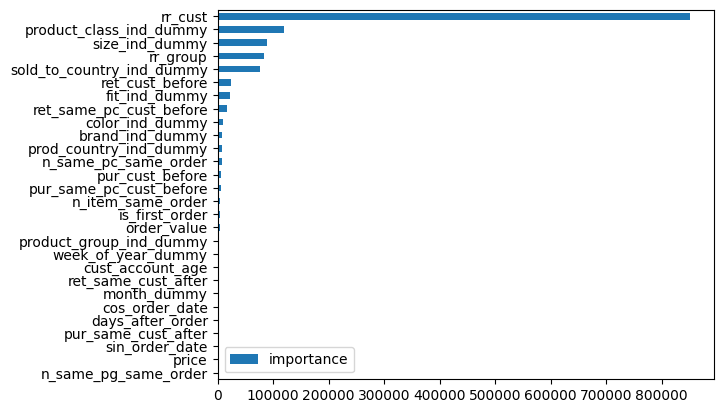

In [43]:
va = model.stages[-2]
lgbm_model = model.stages[-1]

importances = dict(zip(va.getInputCols(), lgbm_model.getFeatureImportances(importance_type='gain')))

importances = pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
importances = importances.sort_values('importance', ascending=True)

importances.plot.barh()

<Axes: >

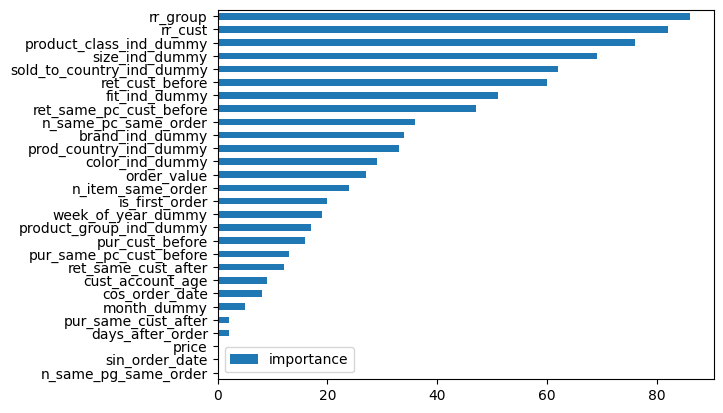

In [44]:
split_importance = dict(zip(va.getInputCols(), lgbm_model.getFeatureImportances(importance_type='split')))

split_importance = pd.DataFrame.from_dict(split_importance, orient='index', columns=['importance'])
split_importance = split_importance.sort_values('importance', ascending=True)

split_importance.plot.barh()

#### Hyperparameter Tuning with Cross-validation
Tuning the model would take too long to do during this training session. However, the process is outlined here for future reference. We can simply create a grid of all hyperparameters we want to try out and perform a full grid search.

Unfortunately, Pyspark's native crossvalidator cannot consider time-series splits, so we will have to create our own approach. The first step is to create a dictionary of all hyperparameter values to try out.

In [45]:
grid = {
    'numLeaves': [200, 400, 600],
    'numIterations': [100],
    'labelCol': ['is_returned']
}

Now we use a function from the itertools package to automatically generate every possible combination of hyperparameters.

In [46]:
import itertools

keys, values = zip(*grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

for comb in combinations:
  print(comb)

{'numLeaves': 200, 'numIterations': 100, 'labelCol': 'is_returned'}
{'numLeaves': 400, 'numIterations': 100, 'labelCol': 'is_returned'}
{'numLeaves': 600, 'numIterations': 100, 'labelCol': 'is_returned'}


Next we order the data by percentiles over the order date. This feature can then be used to create a split between training and validation observations. A double for loop is constructed to iteratively train and evaluate models for every split, for every combination of hyperparameters.

The results per run are saved in a list, which can be reshaped and transformed into a dataframe. We can add the hyperparameters per run in the index and calculate the mean score over all splits per hyperparameter combination.

In [47]:
import time

def tune_hyperparams(df=df, splits=[0.2, 0.4], test_gap=0.1, test_length=0.3,
                     combinations=combinations, verbose=True):

    """ Performs a grid search on a pre-specified grid of hyperparameters by
        splitting the data on order date and iteratively training and evaluating models.

        Input:
            - data to be split into training and testing on time
            - percentile rank to split data on along order_date
            - percentile gap between end of training and start of test data
            - percentile length of test data
            - grid of hyperparameter combinations, as dictionary
            - verbosity: print updates

        Output:
            - dataframe of AUC scores per run and mean score per hyperparameter combination """

    # Rank observations according to the order date
    df = df.withColumn("rank", F.percent_rank().over(psw.partitionBy().orderBy("order_date")))

    # Create placeholder for AUC scores
    auc_scores = []

    # Loop over every combination of hyperparameters
    for i, comb in enumerate(combinations):

      if verbose:
        print(f"Now running combination: {i}, ({comb})")

      # Loop over every time series split in the data
      for j, split in enumerate(splits):

        # Split data in time
        split_train = df.where(f"rank <= {split}").drop("rank")
        split_test = df.where(f"rank > {split + test_gap} and rank <= {split + test_length}").drop("rank")

        # Pass hyperparameters
        pipeline = Pipeline(stages=[indexer, ohe_encoder,
                                    assembler, LightGBMClassifier(**comb)])

        if verbose:
          print(f"Training model for combination: {i}, split: {j}")

        # Record starting time
        start = time.time()

        # Train the model
        model = pipeline.fit(split_train)

        # Record end time
        end = time.time()
        et = np.round((end - start)/60, 1)

        if verbose:
          print(f"Training done -- training time: {et} minutes")

        # Make predictions with model
        df_pred = model.transform(split_test)

        # Save validation AUC
        val_auc = evaluator.evaluate(df_pred)

        # Append the AUC scores for that split
        auc_scores.append(val_auc)

    # Reshape the results based on the number of splits
    scores = pd.DataFrame(np.array(auc_scores).reshape(len(combinations), len(splits)))

    # Calculate row means
    scores['mean'] = scores.mean(axis=1)

    # Set index to hyperparameter combinations
    scores.index = combinations

    # Print max score
    if verbose:
      print("\n", scores.sort_values('mean', ascending=False))

    return scores

scores = tune_hyperparams()

Now running combination: 0, ({'numLeaves': 200, 'numIterations': 100, 'labelCol': 'is_returned'})
Training model for combination: 0, split: 0
Training done -- training time: 7.2 minutes
Training model for combination: 0, split: 1
Training done -- training time: 7.3 minutes
Now running combination: 1, ({'numLeaves': 400, 'numIterations': 100, 'labelCol': 'is_returned'})
Training model for combination: 1, split: 0
Training done -- training time: 7.1 minutes
Training model for combination: 1, split: 1
Training done -- training time: 8.0 minutes
Now running combination: 2, ({'numLeaves': 600, 'numIterations': 100, 'labelCol': 'is_returned'})
Training model for combination: 2, split: 0
Training done -- training time: 7.2 minutes
Training model for combination: 2, split: 1
Training done -- training time: 7.4 minutes

                                                            0         1  \
{'numLeaves': 200, 'numIterations': 100, 'label...  0.795719  0.810736   
{'numLeaves': 400, 'numItera